In [151]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [153]:
# loading and Getting a quick preview of the data before any operation by calling the head method
data = pd.read_csv('healthcare_dataset.csv')
data.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [155]:
# summary statistics for all numeric values
data.describe()

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000


In [157]:
# counting the number of hospitals
hospital_counts = data["Hospital"].value_counts(sort=True)
print(hospital_counts)

Hospital
LLC Smith                      44
Ltd Smith                      39
Johnson PLC                    38
Smith Ltd                      37
Smith PLC                      36
                               ..
and Montoya Flores, Boyer       1
Carter and Dunn King,           1
Hall, Brown Black and           1
Peterson Scott and Thomas,      1
Moreno Murphy, Griffith and     1
Name: count, Length: 39876, dtype: int64


In [159]:
hospital_counts.mean()

1.3918146253385495

In [161]:
hospital_counts.max()

44

In [163]:
hospital_counts.min()

1

In [165]:
#because there was many hospital that were only listed once it was necessary to condiser only hospitals with at least 3 entries
#teh hospital with 3 or more entries were all in the 95th percentil
#function to get the 95th percentil

def pct95(column):
    return column.quantile(0.95)

In [167]:
#threshold to get only the top hospitals

threshold = hospital_counts.agg(pct95)
print(f"Minimum count threshold (95th percentile): {threshold}")

Minimum count threshold (95th percentile): 3.0


In [169]:
#getting the hospital at the threshold and above
hospitals_to_keep = hospital_counts[hospital_counts >= threshold].index

In [171]:
#filtering to get the relevant data
filtered_data = data[data["Hospital"].isin(hospitals_to_keep)]

In [173]:
#check for missing values in each columns
data.isna().sum()

Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

In [175]:
#function to calculate the lenght of stay for each patient
def calculate_length_of_stay(data, admission_col = "Date of Admission", discharge_col="Discharge Date"):
    
    # converting admission and discharge columns into datetime format
    data[admission_col] = pd.to_datetime(data[admission_col])
    data[discharge_col] = pd.to_datetime(data[discharge_col])

    # calculating the length of stay as a difference between admission and discharge
    data["length_of_stay"] = (data[discharge_col] - data[admission_col]).dt.days
    return data


In [177]:
print(data.columns)

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results'],
      dtype='object')


In [179]:
# function that calculate avarage length of stay by medical condition
def average_length_of_stay_by_condition(data, condition_col="Medical Condition", stay_col="length_of_stay"):
    # group by specific medical condition and calculate  the mean length of stay 
    average_stay = data.groupby(condition_col)[stay_col].mean().reset_index()
    average_stay.columns = [condition_col, "Average Length of Stay"]
    return average_stay
                                      
                                        

In [184]:
data = pd.read_csv('healthcare_dataset.csv')
data = calculate_length_of_stay(data)

In [230]:
def calculate_readmission_rate(data, admission_col="Date of Admission", patient_id_cols=["Name","Age","Gender"], threshold_days=30):
    # sort the data by patient identifier and admission data for accurate time difference calculation
    data = data.sort_values(patient_id_cols + [admission_col])

    #calculate the diffrence in days since the last admission for each patient
    data["days_since_last_discharge"] = data.groupby(patient_id_cols)admission_col].diff().dt.days 

    #flaging entries as readmission if they accur within the specified threshol
    data["is_readmission"] = (data["days_since_last_discharge"] <= threshold_days) & (data["days_since_last_discharge"].notna())

    
    #calculate the readmission rate as the percentage of readmission out of total admission 
    total_admission = len(data)
    total_readmission = data["is_readmission"].sum()
    readmission_rate = (total_readmission/ total_admission) * 100
    return readmission_rate

In [232]:
print(data.columns)

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results', 'length_of_stay'],
      dtype='object')


In [234]:
average_length_of_stay = average_length_of_stay_by_condition(data)
print("Average Length of Stay by Condition:\n", average_length_of_stay)

Average Length of Stay by Condition:
   Medical Condition  Average Length of Stay
0         Arthritis               15.517404
1            Asthma               15.696570
2            Cancer               15.495827
3          Diabetes               15.422936
4      Hypertension               15.458626
5           Obesity               15.464305


In [236]:
readmission_rate_30_days = calculate_readmission_rate(data, threshold_days = 30)
print(f"Readmission Rate (30 days): {readmission_rate_30_days:.2f}%")

Readmission Rate (30 days): 0.96%


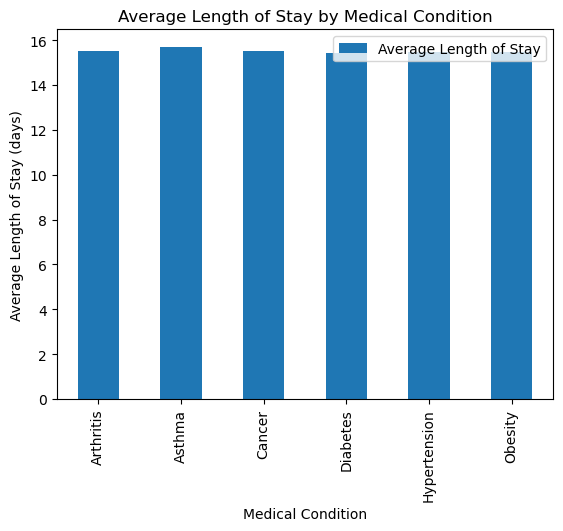

In [238]:
average_length_of_stay.plot(kind='bar', x='Medical Condition', y='Average Length of Stay', title='Average Length of Stay by Medical Condition')
plt.xlabel('Medical Condition')
plt.ylabel('Average Length of Stay (days)')
plt.show() 

In [246]:
data["days_since_last_discharge"] = data.groupby(['Name', 'Age', 'Gender'])['Date of Admission'].diff().dt.days
data["is_readmission"] = (data["days_since_last_discharge"] <= 30) & (data["days_since_last_discharge"].notna())

In [248]:
readmission_rate_by_gender_condition = data.groupby(["Gender","Medical Condition"])["is_readmission"].mean().reset_index()

In [250]:
#converting the readmission rate to percentages
readmission_rate_by_gender_condition["readmission_rate"] = readmission_rate_by_gender_condition["is_readmission"]*100

#view result
print(readmission_rate_by_gender_condition)

    Gender Medical Condition  is_readmission  readmission_rate
0   Female         Arthritis        0.009390          0.938967
1   Female            Asthma        0.009225          0.922469
2   Female            Cancer        0.007823          0.782269
3   Female          Diabetes        0.009030          0.903032
4   Female      Hypertension        0.009324          0.932350
5   Female           Obesity        0.010601          1.060147
6     Male         Arthritis        0.009952          0.995240
7     Male            Asthma        0.010363          1.036269
8     Male            Cancer        0.011027          1.102703
9     Male          Diabetes        0.009886          0.988609
10    Male      Hypertension        0.011008          1.100799
11    Male           Obesity        0.007811          0.781080


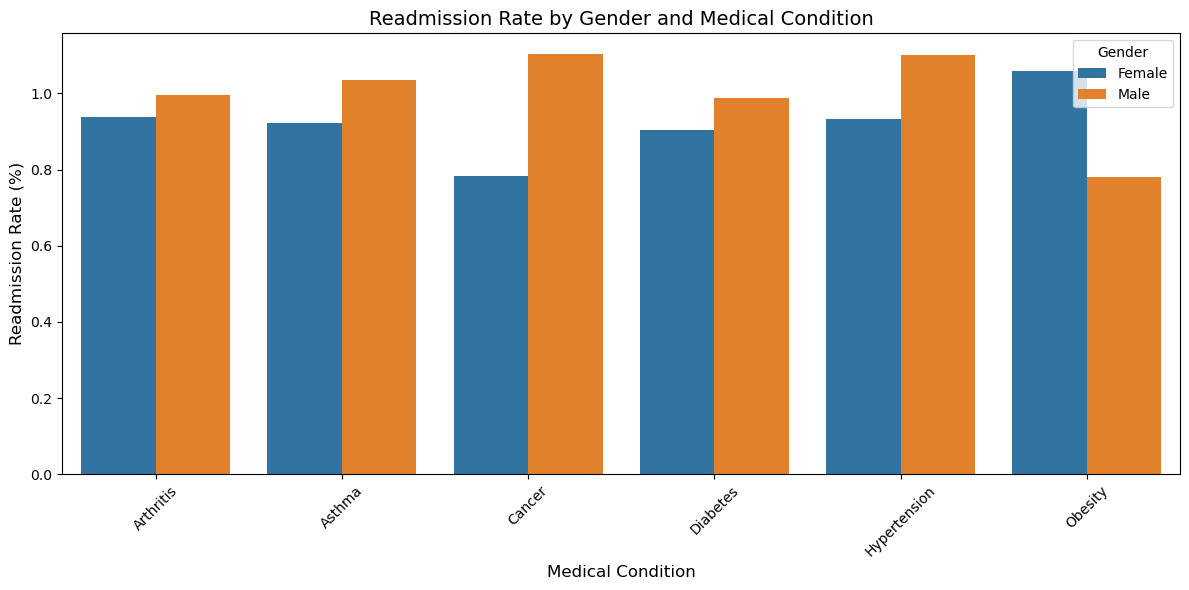

In [252]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=readmission_rate_by_gender_condition, 
    x='Medical Condition', 
    y='readmission_rate', 
    hue='Gender'
)

# Add labels and title
plt.title('Readmission Rate by Gender and Medical Condition', fontsize=14)
plt.xlabel('Medical Condition', fontsize=12)
plt.ylabel('Readmission Rate (%)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Gender')
plt.tight_layout()
plt.show()